In [108]:
import pyomo.environ as pyo
import numpy as np
from pyomo.environ import ConcreteModel,Set,RangeSet,Param,Suffix,Reals,NonNegativeReals,NonPositiveReals,Binary,Objective,minimize,maximize,value
from pyomo.core import Constraint,Var,Block,ConstraintList
from pyomo.opt import SolverFactory, SolverStatus, TerminationCondition
import matplotlib.pyplot as plt
from calculations.datahandling import*
from calculations.data_processor import* 



## Initialization

In [109]:
#--Data handling--
#Read of parameters for portfolio
def InputData(data_file):
    inputdata = pd.read_excel(data_file)
    inputdata = inputdata.set_index('Parameter', drop=True)
    inputdata = inputdata.transpose()
    data = {}
    data['hydro'] = inputdata[['Ci', 'yi', 'P_min', 'P_max']].drop('Solar')
    data['solar']=inputdata[['Ci', 'yi', 'P_min', 'P_max']].drop('Hydro1').drop('Hydro2')
    return data

data = InputData('data/Parameters.xlsx')


#Solar production based on forecast 
def read_solar_data(irrad_file, spec_file, start_date, end_date):
    input_data_PV = read_excel_data(spec_file)
    input_data_Irr = read_irr_data(irrad_file)
    PV_power = pv_power_estimated(input_data_PV,input_data_Irr)
    Solar_1=convert_to_dict(PV_power, start_date, end_date, 'H')
    Solar_p=scale_dict(Solar_1, 1)
    return Solar_p

#Start and end dates of the optimization
start_date='2018-05-28 13:00'
end_date='2018-05-28 13:00'     #Two time steps only

#Original forecast for solar power production
Solar_p=read_solar_data('data/Data_solar_irr_NOR.csv', 'data/PV_spec.xlsx', start_date, end_date)

#Since we are not looking at periods we give a single value to Solar_p: can create scenarios when algorithm works
#Solar_p = 15
#Market = 60

#--Constants--
Constants= {
    'Load_penalty':200, 
    'Hydro_cap':80, 
    'Load':150,
    'Market':60,
}

# ----------------------Mathematical formulation ------------------------- #
# ----- First stage obejctive and constraints ------------------ #
def Obj_1st(model):
    return model.probs*(sum(model.yi[i] * model.p[i] for i in model.plants) - sum(model.Mi[i]*model.p[i] for i in model.plants) + model.alpha) #minimize(power produced - power sold to market)
    
    #return sum(model.yi[i] * model.p[i] for i in model.plants) + sum(model.ki[s] * model.phi[s] for s in model.solar) + sum(model.Li[n] * model.L_p[n] for n in model.penalty) + model.alpha

def p_bounds(model,i):
    return (model.Pmin[i], model.Pmax[i])   


def Hydro_capacity(model, i):
    return model.p[i] <= model.H_stage1[i]

def CreateCuts(model,c):
    return(model.alpha >= model.Phi[c] - sum(model.Lambda[c,i]*(model.p[i]-model.x_hat[c,i]) for i in model.plants))  #only takes into account the hydro power production scheduling from H_cap

# ----- Second stage ojbective and constraints --------------#
def Obj_2nd(model):
    return model.probs*(sum((model.yi[i]*model.p[i] + model.Li * model.L_p) for i in model.plants))

def Solar_rule(model):
    return model.phi == Solar_p

def Hydro_capacity2(model, i):      #ensures that model.p does not use more capacity than what it has available
    return model.p[i] <= model.H_stage2[i]

def load_rule(model):
    return model.p['Hydro1'] + model.p['Hydro2'] + model.phi + model.L_p == model.L 
  
def calculate_initial_H_stage2(Constants, X_hat):
    initial_H_stage2 = {}
    for plant in X_hat:
        remaining_capacity = Constants['Hydro_cap'] - (X_hat[plant])
        initial_H_stage2[plant] = remaining_capacity
    return initial_H_stage2

# ------------------------- MODEL SETUP -------------------------- #

# Set up model 1st stage
def ModelSetUp_1st(data, Constants,Cuts,Scenario):
    model = ConcreteModel()

    # Define sets and parameters specific to the first stage
    model.plants   =  Set(initialize=data['hydro'].index)  # Set of plant types (e.g., 'Hydro1', 'Hydro2')

    #Parameters
    model.Ci       =  pyo.Param(model.plants, initialize=data['hydro']['Ci'])
    model.yi       =  pyo.Param(model.plants, initialize=data['hydro']['yi'])
    model.Pmin     =  pyo.Param(model.plants, initialize=data['hydro']['P_min'])
    model.Pmax     =  pyo.Param(model.plants, initialize=data['hydro']['P_max'])
    model.H_stage1 =  pyo.Param(model.plants, initialize=Constants['Hydro_cap'])     #Initial capacity
    model.Mi       =  pyo.Param(model.plants, initialize=Constants['Market'])        #market sell price
    model.L        =  pyo.Param(initialize=Constants['Load'])
    model.probs    =  pyo.Param(initialize=Scenario)                                 #probability of scenario

    # Variables
    model.p        =  pyo.Var(model.plants, bounds=p_bounds)  # Production from hydro plants

    # Constraints
    model.hydro_cons   =  pyo.Constraint(model.plants, rule=Hydro_capacity)

    # Cuts information
    model.Cut      =  pyo.Set(initialize = Cuts["Set"])
    model.Phi      =  pyo.Param(model.Cut, initialize = Cuts["Phi"])
    model.Lambda   =  pyo.Param(model.Cut, model.plants, initialize = Cuts["lambda"])
    model.x_hat    =  pyo.Param(model.Cut, model.plants, initialize = Cuts["x_hat"])
    
    model.alpha    =  pyo.Var(bounds = (-100000000,100000000))
    
    model.CreateCuts   =  pyo.Constraint(model.Cut, rule = CreateCuts)

    # Define objective function
    model.obj      =  pyo.Objective(rule=Obj_1st, sense=pyo.minimize)
    
    return model



def ModelSetUp_2nd(data, Constants, X_hat, rem_cap, Scenario):
    # Instance
    model          =  pyo.ConcreteModel()

    # Define sets
    model.plants   =  Set(initialize=data['hydro'].index)  # Set of plant types (e.g., 'Hydro1', 'Hydro2')

    # Define parameters
    model.X_hat    =  pyo.Param(model.plants, initialize=X_hat)
    model.Li       =  pyo.Param(initialize=Constants['Load_penalty']) 
    model.yi       =  pyo.Param(model.plants, initialize=data['hydro']['yi'])
    model.Pmin     =  pyo.Param(model.plants, initialize=data['hydro']['P_min'])
    model.Pmax     =  pyo.Param(model.plants, initialize=data['hydro']['P_max'])
    model.H_stage2 =  pyo.Param(model.plants, initialize=rem_cap)
    model.L        =  pyo.Param(initialize=Constants['Load'])
    model.probs    =  pyo.Param(initialize=Scenario)

    # Define variables
    model.p        =  pyo.Var(model.plants, bounds=p_bounds)
    model.phi      =  pyo.Var(within=NonNegativeReals)
    model.L_p      =  pyo.Var(within=NonNegativeReals)

    # Constraints
    model.load_cons    =  pyo.Constraint(rule=load_rule)
    model.solar_cons   =  pyo.Constraint(rule=Solar_rule)
    model.hydro_cons   =  pyo.Constraint(model.plants, rule=Hydro_capacity2)                                           #constraining power production from hydrom from the remaining capacity

    # Define objective function
    model.obj     =  pyo.Objective(rule=Obj_2nd, sense=pyo.minimize)
    
    return model


def Solve(model):
    opt = SolverFactory("gurobi")
    model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
    results = opt.solve(model, load_solutions=True)
    return results, model
def DisplayResults(model):
    return print(model.display(), model.dual.display())


# ----------------------- CUTTING ------------------------ #

# Function for creating new linear cuts for optimization problem
def Cut_manage(Cuts,model):
    """Add new cut to existing dictionary of cut information"""
    
    #Find cut iteration by checking number of existing cuts
    cut = len(Cuts["Set"])
    #Add new cut to list, since 0-index is a thing this works well
    Cuts["Set"].append(cut)
    
    #Find 2nd stage cost result
    Cuts["Phi"][cut] = pyo.value(model.obj)
    #Find lambda x_hat for each type of power produced
    for i in model.plants:
        Cuts["lambda"][cut, i] = model.dual.get(model.hydro_cons[i])  # the lambda should be the economic change when we increase the 1st decision by 1. Should be something else
        Cuts["x_hat"][cut,i] = model.X_hat[i]
    return(Cuts)

Cuts = {}
Cuts["Set"] = []
Cuts["Phi"] = {}
Cuts["lambda"] = {}
Cuts["x_hat"] = {}

scenarios =  {'High':1/3,'Avg':1/3,'Low':1/3}
solar_val_scenario = {'High':30,'Avg':15,'Low':0}

## Bender's decomposition

In [110]:
tot_1st = 0
tot_2nd = 0

hydro1_st1 = []
hydro2_st1 = []
hydro1_st2 = []
hydro2_st2 = []
result_phi = []
result_L_p = []


#initial_alpha = m_1st.alpha.value 
#print(initial_alpha)

for s in scenarios:
    print()
    print('---------------------------------------------------------------------')
    print("Solving for scenario:",s)
    print('---------------------------------------------------------------------')
    Solar_p = solar_val_scenario[s]          #input of solar data to be used in the optimization
    print("The amount of solar power for scenario",s,"is:",Solar_p,"MW")
    tol = 1
    i = 0

    while abs(tol) > 0.1:
        i += 1
        print()
        print('Solving for iteration:',i)
        print()
        #Solve 1st stage problem
        m_1st = ModelSetUp_1st(data, Constants,Cuts,Scenario=scenarios[s])
        Solve(m_1st)

        # Process 1st stage result
        X_hat = {
                "Hydro1": m_1st.p["Hydro1"].value,
                "Hydro2": m_1st.p["Hydro2"].value,
            }
        
        display("How much capacity was used by each plant in stage 1 after solving iteration: "  +  str( i ) + "  " + str(X_hat))

        #Updating remaining capacity between stages
        initial_H_stage2 = calculate_initial_H_stage2(Constants, X_hat,)         #calculate changing capacity between stages
        display("How much capacity is left for each plant in stage 2 after solving iteration: "  +  str( i ) + "  " + str(initial_H_stage2))

        # Setup and solve 2nd stage problem with updated H_stage1
        m_2nd = ModelSetUp_2nd(data, Constants, X_hat, initial_H_stage2, Scenario=scenarios[s])      #must take into account the capacity used in stage 1 as a linking variable
        Solve(m_2nd)

        #Create new cuts for 1st stage problem
        Cuts = Cut_manage(Cuts,m_2nd)
        print("The alpha values are:",m_1st.alpha.value)

        #Print results 2nd stage
        print("Objective function - Second stage:",pyo.value(m_2nd.obj()))

        tol = (pyo.value(m_1st.alpha.value)-pyo.value(m_2nd.obj()))
        print("TOLERANCE",abs(tol))

        #Convergence check
        print("UB:",pyo.value(m_2nd.obj()),"- LB:",pyo.value(m_1st.alpha.value))
        #input()

        print("The first stage objective value is:",m_1st.obj())
        #DisplayResults(m_1st)
        #DisplayResults(m_2nd)

    print("")
    print('--------------------------------->','For scenario:',s,'the cost is:',m_1st.obj(),'<---------------------------------')
    print("")

    tot_1st += m_1st.obj()      #Total costs with respect to the alpha value dervied from the second stage
    print("The total cost is:",tot_1st)

    hydro1_st1.append(m_1st.p['Hydro1'].value)
    hydro2_st1.append(m_1st.p['Hydro2'].value)

    hydro1_st2.append(m_2nd.p['Hydro1'].value)
    hydro2_st2.append(m_2nd.p['Hydro2'].value)
    result_phi.append(m_2nd.phi.value)
    result_L_p.append(m_2nd.L_p.value)


print(">>>>-------------------------------------<<<<")
print("The objective value is:",np.round(tot_1st,2))
print(">>>>-------------------------------------<<<<")


---------------------------------------------------------------------
Solving for scenario: High
---------------------------------------------------------------------
The amount of solar power for scenario High is: 30 MW

Solving for iteration: 1



"How much capacity was used by each plant in stage 1 after solving iteration: 1  {'Hydro1': 60.0, 'Hydro2': 80.0}"

"How much capacity is left for each plant in stage 2 after solving iteration: 1  {'Hydro1': 20.0, 'Hydro2': 0.0}"

The alpha values are: -100000000.0
Objective function - Second stage: 13500.0
TOLERANCE 100013500.0
UB: 13500.0 - LB: -100000000.0
The first stage objective value is: -33334700.0

Solving for iteration: 2



"How much capacity was used by each plant in stage 1 after solving iteration: 2  {'Hydro1': 0.0, 'Hydro2': 0.0}"

"How much capacity is left for each plant in stage 2 after solving iteration: 2  {'Hydro1': 80.0, 'Hydro2': 80.0}"

The alpha values are: -3733.3333333283663
Objective function - Second stage: 1200.0
TOLERANCE 4933.333333328366
UB: 1200.0 - LB: -3733.3333333283663
The first stage objective value is: -1244.4444444427886

Solving for iteration: 3



"How much capacity was used by each plant in stage 1 after solving iteration: 3  {'Hydro1': 39.46666666666666, 'Hydro2': 0.0}"

"How much capacity is left for each plant in stage 2 after solving iteration: 3  {'Hydro1': 40.53333333333334, 'Hydro2': 80.0}"

The alpha values are: 1200.0
Objective function - Second stage: 1264.888888888889
TOLERANCE 64.88888888888891
UB: 1264.888888888889 - LB: 1200.0
The first stage objective value is: -60.44444444444434

Solving for iteration: 4



"How much capacity was used by each plant in stage 1 after solving iteration: 4  {'Hydro1': 39.99999999999999, 'Hydro2': 0.0}"

"How much capacity is left for each plant in stage 2 after solving iteration: 4  {'Hydro1': 40.00000000000001, 'Hydro2': 80.0}"

The alpha values are: 1266.6666666716337
Objective function - Second stage: 1266.6666666666665
TOLERANCE 4.9672053137328476e-09
UB: 1266.6666666666665 - LB: 1266.6666666716337
The first stage objective value is: -44.44444444278868

---------------------------------> For scenario: High the cost is: -44.44444444278868 <---------------------------------

The total cost is: -44.44444444278868

---------------------------------------------------------------------
Solving for scenario: Avg
---------------------------------------------------------------------
The amount of solar power for scenario Avg is: 15 MW

Solving for iteration: 1



"How much capacity was used by each plant in stage 1 after solving iteration: 1  {'Hydro1': 39.99999999999999, 'Hydro2': 0.0}"

"How much capacity is left for each plant in stage 2 after solving iteration: 1  {'Hydro1': 40.00000000000001, 'Hydro2': 80.0}"

The alpha values are: 1266.6666666716337
Objective function - Second stage: 3266.666666666666
TOLERANCE 1999.9999999950323
UB: 3266.666666666666 - LB: 1266.6666666716337
The first stage objective value is: -44.44444444278868

Solving for iteration: 2



"How much capacity was used by each plant in stage 1 after solving iteration: 2  {'Hydro1': 23.56164383561643, 'Hydro2': 0.0}"

"How much capacity is left for each plant in stage 2 after solving iteration: 2  {'Hydro1': 56.43835616438357, 'Hydro2': 80.0}"

The alpha values are: 1211.872146114707
Objective function - Second stage: 1386.8721461187215
TOLERANCE 175.0000000040145
UB: 1386.8721461187215 - LB: 1211.872146114707
The first stage objective value is: 129.07153728937732

Solving for iteration: 3



"How much capacity was used by each plant in stage 1 after solving iteration: 3  {'Hydro1': 24.999999999999993, 'Hydro2': 0.0}"

"How much capacity is left for each plant in stage 2 after solving iteration: 3  {'Hydro1': 55.00000000000001, 'Hydro2': 80.0}"

The alpha values are: 1391.6666666716337
Objective function - Second stage: 1391.6666666666665
TOLERANCE 4.9672053137328476e-09
UB: 1391.6666666666665 - LB: 1391.6666666716337
The first stage objective value is: 172.22222222387796

---------------------------------> For scenario: Avg the cost is: 172.22222222387796 <---------------------------------

The total cost is: 127.77777778108928

---------------------------------------------------------------------
Solving for scenario: Low
---------------------------------------------------------------------
The amount of solar power for scenario Low is: 0 MW

Solving for iteration: 1



"How much capacity was used by each plant in stage 1 after solving iteration: 1  {'Hydro1': 24.999999999999993, 'Hydro2': 0.0}"

"How much capacity is left for each plant in stage 2 after solving iteration: 1  {'Hydro1': 55.00000000000001, 'Hydro2': 80.0}"

The alpha values are: 1391.6666666716337
Objective function - Second stage: 3391.666666666666
TOLERANCE 1999.9999999950323
UB: 3391.666666666666 - LB: 1391.6666666716337
The first stage objective value is: 172.22222222387796

Solving for iteration: 2



"How much capacity was used by each plant in stage 1 after solving iteration: 2  {'Hydro1': 8.561643835616435, 'Hydro2': 0.0}"

"How much capacity is left for each plant in stage 2 after solving iteration: 2  {'Hydro1': 71.43835616438356, 'Hydro2': 80.0}"

The alpha values are: 1336.872146114707
Objective function - Second stage: 2766.6666666666665
TOLERANCE 1429.7945205519595
UB: 2766.6666666666665 - LB: 1336.872146114707
The first stage objective value is: 345.7382039560439

Solving for iteration: 3



"How much capacity was used by each plant in stage 1 after solving iteration: 3  {'Hydro1': 19.999999999999996, 'Hydro2': 0.0}"

"How much capacity is left for each plant in stage 2 after solving iteration: 3  {'Hydro1': 60.0, 'Hydro2': 80.0}"

The alpha values are: 2766.6666666716337
Objective function - Second stage: 2766.6666666666665
TOLERANCE 4.9672053137328476e-09
UB: 2766.6666666666665 - LB: 2766.6666666716337
The first stage objective value is: 688.8888888905445

---------------------------------> For scenario: Low the cost is: 688.8888888905445 <---------------------------------

The total cost is: 816.6666666716338
>>>>-------------------------------------<<<<
The objective value is: 816.67
>>>>-------------------------------------<<<<


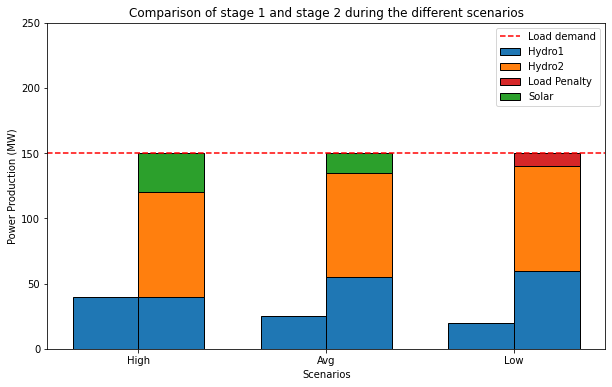

In [111]:

import numpy as np
import matplotlib.pyplot as plt

hydro1_st1 = np.array(hydro1_st1)
hydro1_st2 = np.array(hydro1_st2)
hydro2_st2 = np.array(hydro2_st2)
result_L_p = np.array(result_L_p)
result_phi = np.array(result_phi)

plt.figure(figsize=(10, 6))
bar_width = 0.35
bar_positions_1st = np.arange(len(scenarios)) 
bar_positions_2nd = bar_positions_1st + bar_width 

plt.bar(bar_positions_1st, hydro1_st1, width=bar_width, label=f'Hydro1', color='C0', edgecolor ='black')
plt.bar(bar_positions_2nd, hydro1_st2, width=bar_width, color="C0", edgecolor ='black')
plt.bar(bar_positions_2nd, hydro2_st2, width=bar_width, bottom=hydro1_st2, label=f'Hydro2', color='C1', edgecolor='black')
plt.bar(bar_positions_2nd, result_L_p, width=bar_width, bottom=hydro1_st2 + hydro2_st2, label=f'Load Penalty', color="C3", edgecolor='black')
plt.bar(bar_positions_2nd, result_phi, width=bar_width, bottom=hydro1_st2 + hydro2_st2 + result_L_p, label=f'Solar', color='C2', edgecolor='black')
plt.axhline(y=150, color='red', linestyle='--', label='Load demand')
plt.xlabel('Scenarios')
plt.ylabel('Power Production (MW)')
plt.ylim(0, 250)
plt.title('Comparison of stage 1 and stage 2 during the different scenarios')
plt.xticks(bar_positions_1st + bar_width / 2, scenarios)
plt.legend(loc="upper right")
plt.show()



## Testing code

#REMOVING THE TIME FUNCTION COMPLETELY FROM THE BENDER'S DECOMPOSITION:


#--Data handling--
#Read of parameters for portfolio
def InputData(data_file):
    inputdata = pd.read_excel(data_file)
    inputdata = inputdata.set_index('Parameter', drop=True)
    inputdata = inputdata.transpose()
    data = {}
    data['hydro'] = inputdata[['Ci', 'yi', 'P_min', 'P_max']].drop('Solar')
    data['solar']=inputdata[['Ci', 'yi', 'P_min', 'P_max']].drop('Hydro1').drop('Hydro2')
    return data

data = InputData('data/Parameters.xlsx')


#Solar production based on forecast 
def read_solar_data(irrad_file, spec_file, start_date, end_date):
    input_data_PV = read_excel_data(spec_file)
    input_data_Irr = read_irr_data(irrad_file)
    PV_power = pv_power_estimated(input_data_PV,input_data_Irr)
    Solar_1=convert_to_dict(PV_power, start_date, end_date, 'H')
    Solar_p=scale_dict(Solar_1, 1)
    return Solar_p

#Start and end dates of the optimization
start_date='2018-05-28 13:00'
end_date='2018-05-28 13:00'     #Two time steps only

#Original forecast for solar power production
Solar_p=read_solar_data('data/Data_solar_irr_NOR.csv', 'data/PV_spec.xlsx', start_date, end_date)

#Since we are not looking at periods we give a single value to Solar_p: can create scenarios when algorithm works
Solar_p = 10

#Unique scenarios for stochastic variable
S_high=Solar_p*1.5
S_avg=Solar_p*1
S_low=Solar_p*0.5

#Load 
#L= {1:50} #3:20, 4:30, 5:50, 6:80, 7:50, 8:90, 9:110, 10:150, 11:120, 12:80, 13:70, 14:80, 15:90, 16:160, 17:170, 18:150, 19:120, 20:100, 21:70, 22:60, 23:50, 24:40} 

Market = 30

#--Constants--
Constants= {
    'Load_penalty':100, 
    'Hydro_cap':50, 
    'Load':150,
    'probs':{'S_high':1/3, 'S_avg':1/3, 'S_low':1/3},    
}

# ----------------------Mathematical formulation ------------------------- #
# ----- First stage obejctive and constraints ------------------ #
def Obj_1st(model):
    return sum(model.yi[i] * model.p[i] for i in model.plants) - sum(model.m[i]*model.p[i] for i in model.plants) #minimize(power produced - power sold to market)
    
def p_bounds(model,i):
    return (model.Pmin[i], model.Pmax[i])   


def Hydro_capacity(model, i):
    return model.p[i] <= model.H_stage1[i]

def CreateCuts(model,c):
    return(model.alpha >= model.Phi[c] + sum(model.Lambda[c,i]*(model.p[i]-model.x_hat[c,i]) for i in model.plants))


# ----- Second stage ojbective and constraints --------------# -- IMPLEMENT scenarios to have Stochasticity in the second stage decision.
def Obj_2nd(model):
    return sum(model.probs[l] * (model.yi[i]*model.p[i] + model.phi[l] + model.Li[n] * model.L_p[n]) for i in model.plants for l in model.scenarios for n in model.penalty)

#model.ki[s] *

#def Solar_rule(model,l):
#    return model.phi['Solar',l] == Solar_p

def Solar_high(model):
    if model.probs['S_high']>0:
        return model.phi['S_high']==S_high
    else:
        return model.phi['S_high']==0
    
#Solar production in stage 2 must be equal to scenario for average production
def Solar_avg(model):
    if model.probs['S_avg']>0:
        return  model.phi['S_avg'] == S_avg
    else:
        return  model.phi['S_avg'] == 0
    
#Solar production in stage 2 must be equal to scenario for low production
def Solar_low(model):
    if model.probs['S_low']>0:
        return  model.phi['S_low'] == S_low
    else:
        return  model.phi['S_low'] == 0
    

def Hydro_capacity2(model, i):      #ensures that model.p does not use more capacity than what it has available
    return model.p[i] <= model.H_stage2[i]

def load_rule(model,l):
    return model.p['Hydro1'] + model.p['Hydro2'] + model.phi['Solar',l] + model.L_p['Load_penalty'] == model.L 

def calculate_initial_H_stage2(Constants, X_hat):
    initial_H_stage2 = {}
    for plant in X_hat:
        remaining_capacity = Constants['Hydro_cap'] - (X_hat[plant])
        initial_H_stage2[plant] = remaining_capacity
    return initial_H_stage2

# ------------------------- MODEL SETUP -------------------------- #

# Set up model 1st stage
def ModelSetUp_1st(data, Constants,Cuts):
    model = ConcreteModel()

    # Define sets and parameters specific to the first stage
    model.plants = Set(initialize=data['hydro'].index)  # Set of plant types (e.g., 'Hydro1', 'Hydro2')

    #Parameters
    model.Ci=pyo.Param(model.plants, initialize=data['hydro']['Ci'])
    model.yi=pyo.Param(model.plants, initialize=data['hydro']['yi'])
    model.Pmin=pyo.Param(model.plants, initialize=data['hydro']['P_min'])
    model.Pmax=pyo.Param(model.plants, initialize=data['hydro']['P_max'])
    model.H_stage1 = pyo.Param(model.plants, initialize=Constants['Hydro_cap'])     #Initial capacity
    model.m = pyo.Param(model.plants, initialize=Market)   #market sell price

    model.L = pyo.Param(initialize=Constants['Load'])


    # Variables
    model.p   = pyo.Var(model.plants, bounds=p_bounds)  # Production from hydro plants

    # Constraints
    model.hydro_cons=pyo.Constraint(model.plants, rule=Hydro_capacity)

    """Cuts_information"""
    #Set for cuts
    model.Cut = pyo.Set(initialize = Cuts["Set"])
    #Parameter for cuts
    model.Phi = pyo.Param(model.Cut, initialize = Cuts["Phi"])
    model.Lambda = pyo.Param(model.Cut, model.plants, initialize = Cuts["lambda"])
    model.x_hat = pyo.Param(model.Cut, model.plants, initialize = Cuts["x_hat"])
    #Variable for alpha
    model.alpha = pyo.Var(bounds = (-100000000,100000000))
    
    """Constraint cut"""
    model.CreateCuts = pyo.Constraint(model.Cut, rule = CreateCuts)


    """Constraints"""
    # Define objective function
    model.obj = pyo.Objective(rule=Obj_1st, sense=pyo.minimize)
    
    return model


def ModelSetUp_2nd(data, Constants, X_hat, rem_cap):
    # Instance
    model = pyo.ConcreteModel()
    # Define sets
    model.plants = Set(initialize=data['hydro'].index)  # Set of plant types (e.g., 'Hydro1', 'Hydro2')
    #model.solar = Set(initialize=data['solar'].index)  # Set of solar types (e.g., 'Solar') ->used for solar cost
    model.penalty= Set(initialize=['Load_penalty']) 
    model.scenarios = Set(initialize=Constants['probs'].keys())

    # Define parameters
    model.X_hat = pyo.Param(model.plants, initialize=X_hat)
    model.Li=pyo.Param(model.penalty, initialize=Constants['Load_penalty'])
    model.yi=pyo.Param(model.plants, initialize=data['hydro']['yi'])
    #model.ki=pyo.Param(model.solar, initialize=data['solar']['yi'])  #solar is free and will always be utilizied
    model.Pmin=pyo.Param(model.plants, initialize=data['hydro']['P_min'])
    model.Pmax=pyo.Param(model.plants, initialize=data['hydro']['P_max'])
    #model.Phi_min=pyo.Param(model.scenarios, initialize=data['solar']['P_min'])
    #model.Phi_max=pyo.Param(model.scenarios, initialize=data['solar']['P_max'])
    model.H_stage2 = pyo.Param(model.plants, initialize=rem_cap)
    model.probs=pyo.Param(model.scenarios, initialize=Constants['probs'])       #Scenarios indexed by "l"
    model.L = pyo.Param(initialize=Constants['Load'])
    
    # Define variables
    model.p   = pyo.Var(model.plants, bounds=p_bounds)
    model.phi = pyo.Var(model.scenarios, within=NonNegativeReals)
    model.L_p = pyo.Var(model.penalty, within=NonNegativeReals)

    #Constraints
    model.high_sun= pyo.Constraint(rule=Solar_high)
    model.avg_sun= pyo.Constraint(rule=Solar_avg)
    model.low_sun= pyo.Constraint(rule=Solar_low)

    model.load_cons  = pyo.Constraint(model.scenarios, rule=load_rule)
    model.hydro_cons = pyo.Constraint(model.plants, rule=Hydro_capacity2)  #constraining power production from hydrom from the remaining capacity
    
    #Stochastic constraints

    # Define objective function
    model.obj = pyo.Objective(rule=Obj_2nd, sense=pyo.minimize)
    
    return model


def Solve(model):
    opt = SolverFactory("gurobi")
    model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
    results = opt.solve(model, load_solutions=True)
    return results, model
def DisplayResults(model):
    return print(model.display(), model.dual.display())


# ----------------------- CUTTING ------------------------ #

# Function for creating new linear cuts for optimization problem
def Cut_manage(Cuts,model):
    """Add new cut to existing dictionary of cut information"""
    
    #Find cut iteration by checking number of existing cuts
    cut = len(Cuts["Set"])
    #Add new cut to list, since 0-index is a thing this works well
    Cuts["Set"].append(cut)
    
    #Find 2nd stage cost result
    Cuts["Phi"][cut] = pyo.value(model.obj)
    #Find lambda x_hat for each type of power produced
    for i in model.plants:
        Cuts["lambda"][cut, i] = model.dual.get(model.hydro_cons[i])  # the lambda should be the economic change when we increase the 1st decision by 1, => dual value of hydro prod
        Cuts["x_hat"][cut,i] = model.X_hat[i]
    return(Cuts)

Cuts = {}
Cuts["Set"] = []
Cuts["Phi"] = {}
Cuts["lambda"] = {}
Cuts["x_hat"] = {}

#X_hat = {
#    "Hydro1": 0.0,
#    "Hydro2": 0.0,
#}

#This is the while-loop in principle, but for this case is only a for-loop

#CODE FOR LATER WHEN LOGIC WORKS:
#tol = 1e-4     #tolerance for while loop
#while (pyo.value(m_1st.alpha.value - pyo.value(m_2nd.obj)) >= tol): #while loop that doesn't end until upper bound and lower bound converge (not working so something similar)



#For now:
for i in range(5):

    #Solve 1st stage problem
    m_1st = ModelSetUp_1st(data, Constants,Cuts)
    Solve(m_1st)
 
 
    # Process 1st stage result
    X_hat = {
            "Hydro1": m_1st.p["Hydro1"].value,
            "Hydro2": m_1st.p["Hydro2"].value,

        }
    display(X_hat)
    DisplayResults(m_1st)
    
    #Updating remaining capacity between stages
    initial_H_stage2 = calculate_initial_H_stage2(Constants, X_hat)         #calculate changing voluem
    display("How much capacity is left for each plant for stage 2 after solving loop: " +  str( i ) + "  " + str(initial_H_stage2))

    # Setup and solve 2nd stage problem with updated H_stage1
    m_2nd = ModelSetUp_2nd(data, Constants, X_hat, initial_H_stage2)      #must take into account the capacity used in stage 1 as a linking variable
    Solve(m_2nd)
    DisplayResults(m_2nd)
    #Create new cuts for 1st stage problem
    Cuts = Cut_manage(Cuts,m_2nd)
    print()
    print()

    #Print results 2nd stage
    print("Objective function:",pyo.value(m_2nd.obj))
    print("Cut information acquired:")
    for component in Cuts:
        if component == "lambda" or component == "x_hat":
            for j in m_2nd.plants:
                print(component,j,Cuts[component][i,j])
        else:
            print(component,Cuts[component])
    
    #We perform a convergence check
    print("UB:",pyo.value(m_1st.alpha.value),"- LB:",pyo.value(m_2nd.obj))
    #input()
